In [21]:
import geopandas as gpd
import os
import glob
import pdal
import json
import numpy as np
import shutil

## Selecionando as Quadrículas para Processamento

In [2]:
gdf_quadriculas = gpd.read_file('zip://dados/SIRGAS_SHP_quadriculamdt.zip!SIRGAS_SHP_quadriculamdt', epsg='31983')

In [3]:
gdf_quadriculas.set_crs(epsg='31983', inplace=True)

,qmdt_cod,geometry
0,3212-353,"POLYGON ((329132.004 7367829.458, 329125.190 7..."
1,3212-344,"POLYGON ((328601.255 7367823.210, 328594.420 7..."
2,3212-343,"POLYGON ((328070.502 7367816.960, 328063.648 7..."
3,3211-464,"POLYGON ((327539.756 7367810.622, 327532.876 7..."
4,3211-463,"POLYGON ((327008.999 7367804.285, 327002.102 7..."
...,...,...
5357,3234-241,"POLYGON ((331960.582 7352864.137, 331967.325 7..."
5358,3234-224,"POLYGON ((333544.473 7353459.402, 333551.152 7..."
5359,3336-444,"POLYGON ((331725.429 7373051.662, 332256.363 7..."
5360,3336-442,"POLYGON ((331718.736 7373628.441, 332249.692 7..."


In [4]:
gdf_marcos = gpd.read_file('dados/SIRGAS_GPKG_apoiocampo.gpkg')

In [5]:
gdf_quadriculas_marcos = gdf_quadriculas.sjoin(gdf_marcos, how='inner')

<AxesSubplot:>

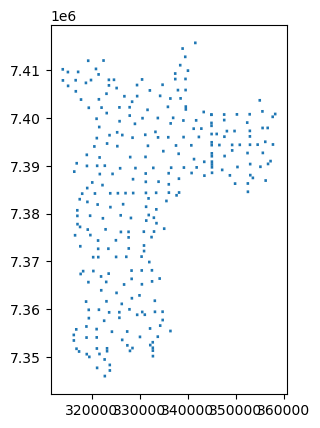

In [6]:
gdf_quadriculas_marcos.plot()

## Processando as Quadrículas selecionadas

In [25]:
DATA_DIR_2020 = '/media/fernando/DATA/LiDAR-Sampa-2020'
DATA_DIR_2017 = '/media/fernando/DATA/LiDAR-Sampa-2017'

In [10]:
class Scm:

    def __init__(self, scm) -> None:
        
        coords = [[xy[0], xy[1]] for xy in gdf_quadriculas.set_index('qmdt_cod').loc[scm].geometry.exterior.coords]
        xy_max = np.max(np.array(coords), axis=0) 
        xy_min = np.min(np.array(coords), axis=0)
        width, height = np.ceil(xy_max * 2) - np.ceil(xy_min * 2)

        origin_x, origin_y = np.floor(xy_min * 2)/2
        
        self.scm = scm
        self.width = width
        self.height = height
        self.origin_x = origin_x
        self.origin_y = origin_y

In [39]:
def pipeline(scm, ano):
    # Retorna o json com o Pipeline para o determinado SCM
    scm_att = Scm(scm)
    pipeline = [
        {
            "type": "readers.las",
            "filename": f'temp/{ano}-{scm}.laz',
            "override_srs": "EPSG:31983"
        },
        {
            "type":"filters.range",
            "limits":"Classification[2:2]"
        },
        {
            "type": "filters.delaunay"
        },
        {
            "type": "filters.faceraster",
            "resolution":"0.5",
            "width": scm_att.width,
            "height": scm_att.height,
            "origin_x": scm_att.origin_x,
            "origin_y": scm_att.origin_y,
        },        
        {
            "filename":f"resultados/{ano}/MDT/MDT-{scm}-{ano}-50cm.tiff",
            "gdaldriver":"GTiff",
            "type": "writers.raster",
            "gdalopts":"COMPRESS=ZSTD, PREDICTOR=3, BIGTIFF=YES",
            "nodata":"0",
            "data_type": "float32",
            # "default_srs": "EPSG:31983"
        }
    ]
    return pipeline

In [40]:
def processa(scm, ano):

    # Copia arquivos de 2017 e 2020 para uma pasta temporária
    file_2017 = glob.glob(f'{DATA_DIR_2017}/*{scm}*.laz')
    file_2020 = glob.glob(f'{DATA_DIR_2020}/*{scm}*.laz')
    if len(file_2017) != 1 or len(file_2020) != 1:
        raise ValueError(f'Os arquivos do {scm} parecem não conforme!')

    # copia arquivo para a pasta temporaria
    print(f'Processando {scm}')

    shutil.copy(file_2017[0], f'temp/2017-{scm}.laz')
    shutil.copy(file_2020[0], f'temp/2020-{scm}.laz')

    mdt_mds = pdal.Pipeline(json.dumps(pipeline(scm, ano)))
    n_points = mdt_mds.execute()

    # Exclui os arquivos da pasta temporária
    os.remove(f'temp/2017-{scm}.laz')
    os.remove(f'temp/2020-{scm}.laz')    


In [41]:
for i, quadricula in gdf_quadriculas_marcos.iterrows():
    q = quadricula.qmdt_cod
    print(q)
    processa(q, 2017)
    processa(q, 2020)
    # break


3212-343


In [42]:
processa('3212-343', 2017)

Processando 3212-343
